In [1]:
!make build

---------CLEANING---------
rm -f lib/*.a
rm -f matmul_methods*
rm -f sourcecode_matmul_methods.cpp
rm -rf build
--------------------------
----COMPILE CUDA FILES----
nvcc --compiler-options -fPIC -lib -odir lib -o lib/libmatmul.a cuda/matmul.cu 
--------------------------
---COMPILE CYTHON FILES---
python3 compile_cython.py build_ext --inplace
{'home': '/usr/local/cuda', 'nvcc': '/usr/local/cuda/bin/nvcc', 'include': '/usr/local/cuda/include', 'lib64': '/usr/local/cuda/lib64'}
running build_ext
cythoning sourcecode_matmul_methods.pyx to sourcecode_matmul_methods.cpp
/usr/local/lib/python3.8/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /home/ikilbas/RAIL/HPC/lab1/sourcecode_matmul_methods.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'matmul_methods' extension
creating build
creating build/temp.linux-x86_64-3.8
x86_64-linux-gnu-gcc -pthread -Wno-un

In [2]:
from matmul_methods import cuda_matmul, cpu_matmul, cpu_openmp_matmul
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from timeit import timeit

Check correctness

In [3]:
A = np.random.randint(50, size=(3, 4)).astype(np.float32)
B = np.random.randint(50, size=(4, 5)).astype(np.float32)
C = np.matmul(A, B).astype(np.float32)

Af = A.astype(np.float32, order="F")
Bf = B.astype(np.float32, order="F")
Cf = C.astype(np.float32, order="F")

A, B, C

(array([[12., 26., 42., 42.],
        [23., 41., 49.,  0.],
        [31.,  0., 28., 13.]], dtype=float32),
 array([[23.,  7., 19., 28., 43.],
        [36., 47., 29., 48., 35.],
        [31., 27., 28., 13., 36.],
        [38., 14., 32.,  8., 46.]], dtype=float32),
 array([[4110., 3028., 3502., 2466., 4870.],
        [3524., 3411., 2998., 3249., 4188.],
        [2075., 1155., 1789., 1336., 2939.]], dtype=float32))

In [4]:
Cf1 = np.empty_like(Cf)
cuda_matmul(Af, Bf, Cf1)
Cf1

array([[4110., 3028., 3502., 2466., 4870.],
       [3524., 3411., 2998., 3249., 4188.],
       [2075., 1155., 1789., 1336., 2939.]], dtype=float32)

In [5]:
C2 = np.empty_like(C)
cpu_matmul(A, B, C2)
C2

array([[4110., 3028., 3502., 2466., 4870.],
       [3524., 3411., 2998., 3249., 4188.],
       [2075., 1155., 1789., 1336., 2939.]], dtype=float32)

In [6]:
C3 = np.empty_like(C)
cpu_openmp_matmul(A, B, C3)
C3

array([[4110., 3028., 3502., 2466., 4870.],
       [3524., 3411., 2998., 3249., 4188.],
       [2075., 1155., 1789., 1336., 2939.]], dtype=float32)

In [7]:
np.array_equal(C, Cf1), np.array_equal(C, C2), np.array_equal(C, C3)

(True, True, True)

Stress test

(going to be testing only square matrices)

In [8]:
dims_to_test = [2**i for i in range(3, 12)]
repeats = 5

df = pd.DataFrame(columns=('CPU', 'CPU OPENMP', 'GPU'))

In [9]:
for n in dims_to_test:
    
    print(f'test n={n}')
    
    A = np.random.randint(100, size=(n, n)).astype(np.float32)
    B = np.random.randint(100, size=(n, n)).astype(np.float32)
    C = np.matmul(A, B).astype(np.float32)

    Af = A.astype(np.float32, order="F")
    Bf = B.astype(np.float32, order="F")
    Cf = C.astype(np.float32, order="F")
    
    Cf1 = np.empty_like(Cf)
    C2 = np.empty_like(C)
    C3 = np.empty_like(C)
    
    cuda_matmul(Af, Bf, Cf1)
    cpu_matmul(A, B, C2)
    cpu_openmp_matmul(A, B, C3)
    
    assert np.array_equal(C, Cf1)
    assert np.array_equal(C, C2)
    assert np.array_equal(C, C3)
    
        
    gpu_times = np.zeros(repeats, dtype=np.float)
    for i in range(repeats):
        gpu_times[i] = cuda_matmul(Af, Bf, Cf1)
    gpu_time = gpu_times.mean()  # in ms
        
    cpu_time = timeit(lambda: cpu_matmul(A, B, C2), number=repeats) / repeats  # in sec
    cpu_time *= 1000  # in ms
    
    cpu_openmp_time = timeit(lambda: cpu_openmp_matmul(A, B, C3), number=repeats) / repeats  # in sec
    cpu_openmp_time *= 1000  # in ms
    
    df.loc[n] = [cpu_time, cpu_openmp_time, gpu_time]
    

test n=8
test n=16
test n=32
test n=64
test n=128
test n=256
test n=512
test n=1024
test n=2048


In [10]:
df

,CPU,CPU OPENMP,GPU
8,0.004743,0.163313,0.014157
16,0.010795,0.122105,0.013190
32,0.058045,0.128014,0.016186
64,0.317804,0.175761,0.014150
128,5.035665,0.576763,0.025280
256,22.050053,5.750790,0.025139
512,216.300257,27.472460,0.050291
1024,2635.734687,305.527912,0.232941
2048,27985.670959,2744.516414,1.627123


In [11]:
xticks = range(len(df.index))
xticklabels = df.index.tolist()

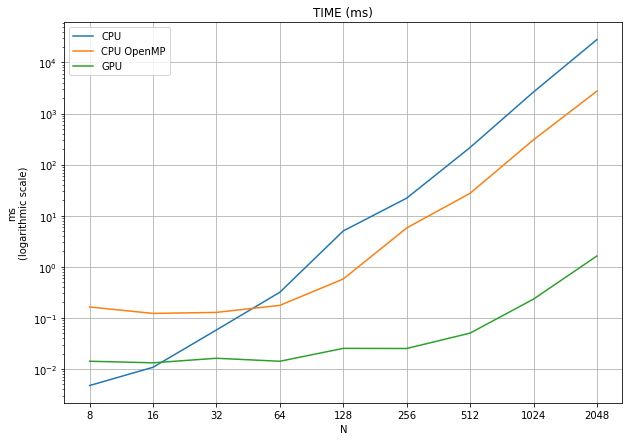

In [12]:
plt.figure(figsize=(10, 7))

ax = plt.axes()
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)

plt.title('TIME (ms)')
plt.yscale('log')

plt.xlabel('N')
plt.ylabel('ms\n(logarithmic scale)')

plt.plot(df['CPU'].tolist(), label='CPU')
plt.plot(df['CPU OPENMP'].tolist(), label='CPU OpenMP')
plt.plot(df['GPU'].tolist(), label='GPU')

plt.grid()
plt.legend()

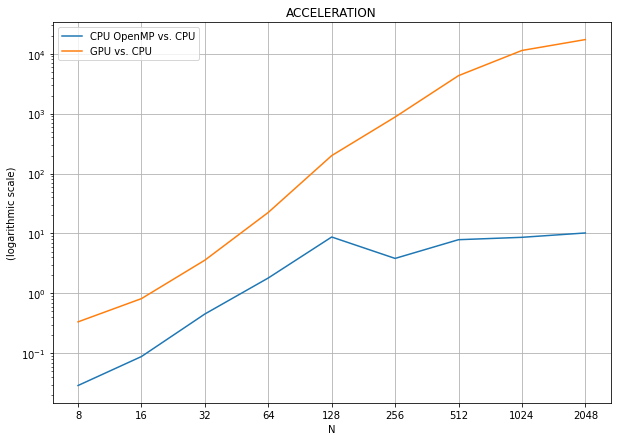

In [13]:
plt.figure(figsize=(10, 7))

ax = plt.axes()
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)

plt.title('ACCELERATION')
plt.yscale('log')

plt.xlabel('N')
plt.ylabel('(logarithmic scale)')

plt.plot((df['CPU'] / df['CPU OPENMP']).tolist(), label='CPU OpenMP vs. CPU')
plt.plot((df['CPU'] / df['GPU']).tolist(), label='GPU vs. CPU')

plt.grid()
plt.legend()

In [14]:
print(df.to_markdown())

|      |            CPU |   CPU OPENMP |       GPU |
|-----:|---------------:|-------------:|----------:|
|    8 |     0.00474341 |     0.163313 | 0.0141568 |
|   16 |     0.010795   |     0.122105 | 0.0131904 |
|   32 |     0.0580452  |     0.128014 | 0.0161856 |
|   64 |     0.317804   |     0.175761 | 0.0141504 |
|  128 |     5.03566    |     0.576763 | 0.02528   |
|  256 |    22.0501     |     5.75079  | 0.0251392 |
|  512 |   216.3        |    27.4725   | 0.0502912 |
| 1024 |  2635.73       |   305.528    | 0.232941  |
| 2048 | 27985.7        |  2744.52     | 1.62712   |
